In [1]:
import sys
import os
from glob import glob
import random
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm

from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
use_colab = False
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    sys.path.append('/content/drive/MyDrive/BrainMri')
    os.getcwd()

In [3]:
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

# File path line length images for later sorting
sample_path = os.path.join(DATA_PATH, 'TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif')
BASE_LEN = 89
END_IM_LEN = 4
END_MASK_LEN = 9

# Image size
IM_SIZE = 512

In [4]:
from pathlib import Path

# Raw data
data_map = []
for sub_dir_path in glob(DATA_PATH + "*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = os.path.join(sub_dir_path, filename)
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)

This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


In [5]:
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

dirname                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [6]:
df['path'].str.contains('mask').value_counts()

True     3929
False    3929
Name: path, dtype: int64

In [7]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains('mask')]
df_masks = df[df['path'].str.contains('mask')]

# Data sorting
imgs = sorted(df_imgs['path'].values, key=lambda x : int(x[BASE_LEN:-END_IM_LEN]))
masks = sorted(df_masks['path'].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sanity check
print(len(imgs), len(masks))

idx = random.randint(0, len(imgs) - 1)
print(f'Path to Image: {imgs[idx]}, \nPath to Mask: {masks[idx]}')

3929 3929
Path to Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_11.tif, 
Path to Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_11_mask.tif


In [8]:
df_imgs

dirname                                               path
0     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
5     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...                     ...                                                ...
7849  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7850  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7852  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7854  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7856  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

[3929 rows x 2 columns]

In [9]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                    "image_path": imgs,
                    "mask_path": masks})

In [10]:
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0: 
        return 1
    return 0

df['diagnosis'] = df['mask_path'].apply(lambda mp: pos_neg_diagnosis(mp))
df

patient  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  diagnosis  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
...                                                 ...        ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  

[3929 rows x 4 columns]

Text(1.2, 2550, 'Total 3929 images')

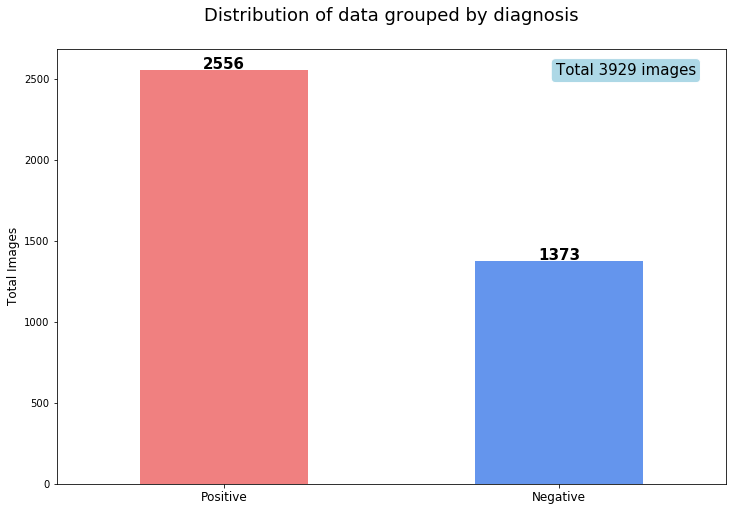

In [11]:
ax = df.diagnosis.value_counts().plot(kind='bar',
                                     stacked=True,
                                     figsize=(12, 8),
                                     color=['lightcoral', 'cornflowerblue'])

ax.set_xticklabels(['Positive', 'Negative'], rotation=0, fontsize=12)
ax.set_ylabel('Total Images', fontsize=12)
ax.set_title('Distribution of data grouped by diagnosis', fontsize=18, y=1.05)

for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), 
                xy=(i, rows - 12),
                rotation=0, 
                color='k',
                ha='center',
                verticalalignment='bottom', 
                fontsize=15,
                fontweight='bold')
    
ax.text(1.2, 2550, f'Total {len(df)} images', 
        size=15, 
        color='k',
        ha='center', 
        va='center',
        bbox=dict(boxstyle='round', fc=('lightblue'), ec=('w')))

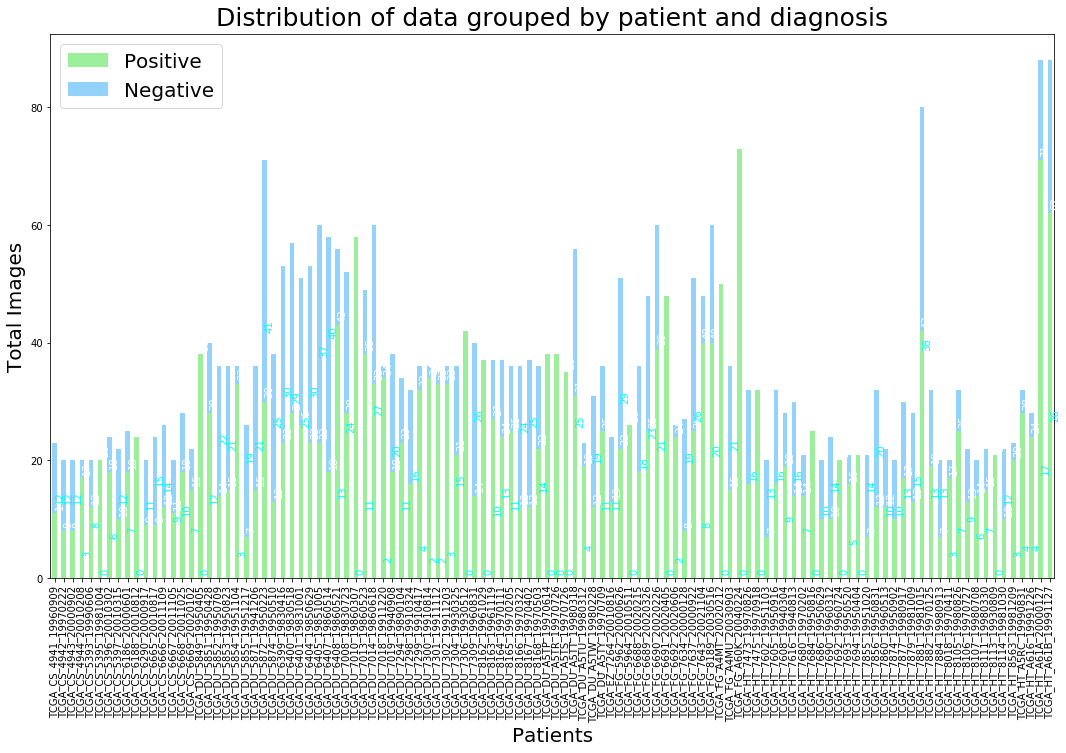

In [12]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["lightgreen", "lightskyblue"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# Annotations
for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")

### Data Visualization

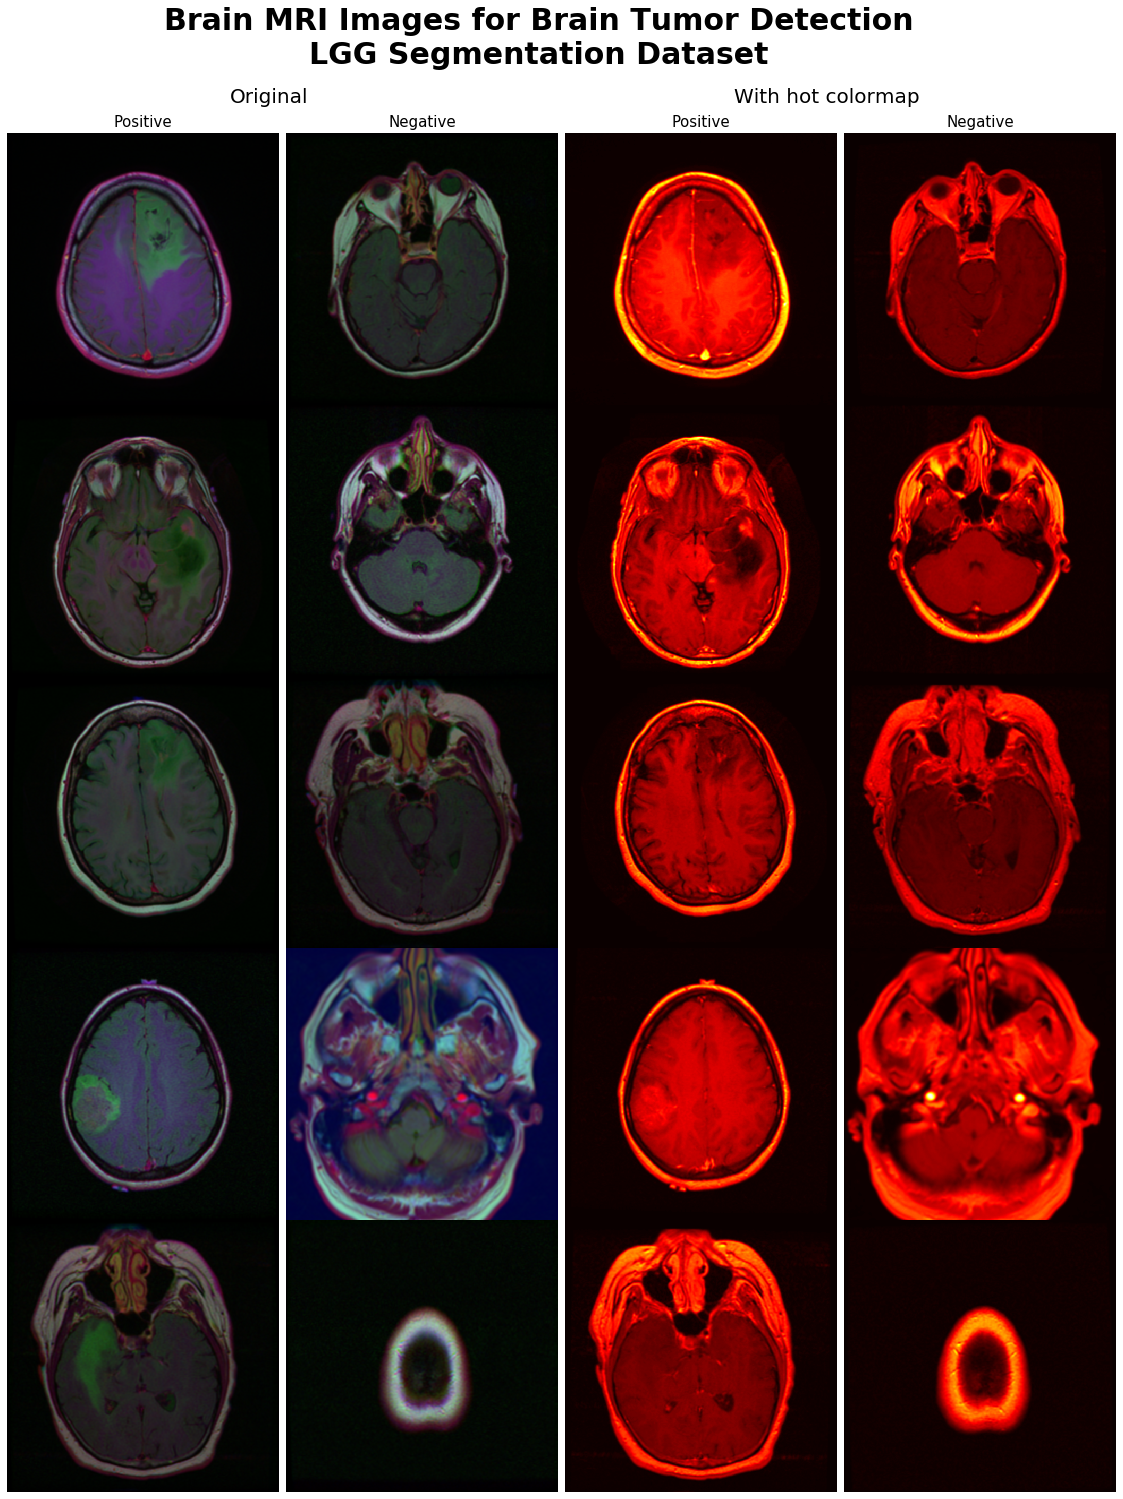

In [13]:
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IM_SIZE, IM_SIZE))
    no = cv2.resize(cv2.imread(no), (IM_SIZE, IM_SIZE))
    sample_imgs.extend([yes, no])

sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 4), 
                 axes_pad=0.1,  # pad between axes in inch.
                 )

grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")

grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")

grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")

# annotations
plt.figtext(0.35,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

Samples of positive diagnosis images and masks 

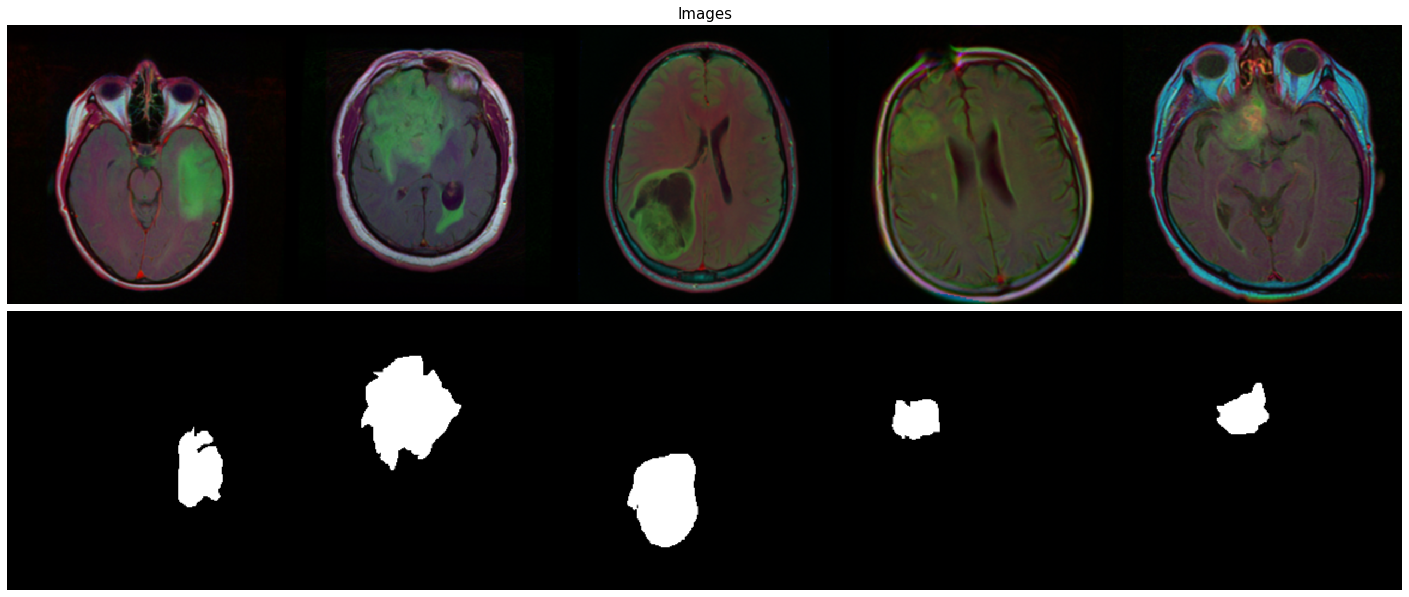

In [14]:
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    # print(data)
    img = cv2.resize(cv2.imread(data[1]), (IM_SIZE, IM_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IM_SIZE, IM_SIZE))
    sample_imgs.extend([img, mask])
sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)

grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")

grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")

plt.show()

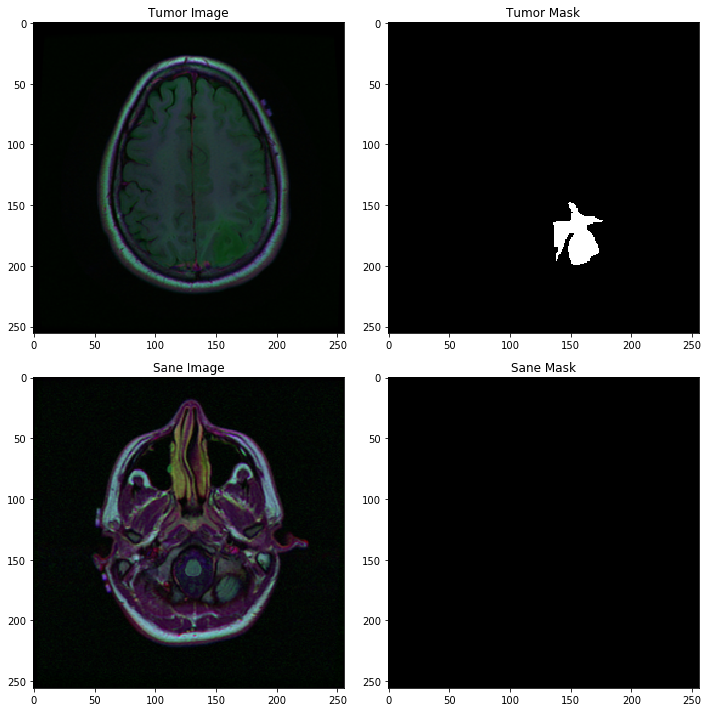

In [15]:
sample_tumor_index = df[df["diagnosis"] == 1].sample(1).index
sample_sane_index = df[df["diagnosis"] == 0].sample(1).index

tumor_image_path = df.iloc[sample_tumor_index]["image_path"].values[0]
sane_image_path = df.iloc[sample_sane_index]["image_path"].values[0]
tumor_mask_path = df.iloc[sample_tumor_index]["mask_path"].values[0]
sane_mask_path = df.iloc[sample_sane_index]["mask_path"].values[0]

paths = [tumor_image_path, tumor_mask_path, sane_image_path, sane_mask_path]

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    img = cv2.imread(paths[i])

    # Convert the image from BGR to RGB
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img)

    # Set the title
    if i == 0:
        ax.set_title('Tumor Image')
    elif i == 1:
        ax.set_title('Tumor Mask')
    elif i == 2:
        ax.set_title('Sane Image')
    else:
        ax.set_title('Sane Mask')

# Display the plot
plt.tight_layout()
plt.show()

## Data Generator and Data Augmentation

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [18]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image'] # (3, 255, 255)
        mask = augmented['mask']   # (255, 255)
        
        mask = np.expand_dims(mask, axis=0) # (1, 255, 255)
            
        # unnormilize mask
        # mask = torch.clamp(mask.float(), min=0, max=1)
        # mask = torch.ceil(mask)   
        
        return image, mask


In [19]:
PATCH_SIZE = 128 # 256

strong_transforms = A.Compose([
    A.RandomResizedCrop(width=PATCH_SIZE, height=PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
    
    
    A.Normalize(p=1.0),
    ToTensorV2(),
])

transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    A.Normalize(p=1.0),
    ToTensorV2(),
])

In [20]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [21]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=True)

In [22]:
img, mask = train_dataset[0]
print(img.shape, mask.shape)
print(img, mask)

imgs, masks = next(iter(train_dataloader))
print(f'Images batch shape: {imgs.shape}')
print(f'Masks batch shape: {masks.shape}')

torch.Size([3, 128, 128]) (1, 128, 128)
tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0007,  ..., -2.0182, -2.0182, -2.0357],
         ...,
         [-2.0357, -2.0182, -2.0007,  ..., -2.0182, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0182,  ..., -2.0182, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
     

torch.Size([32, 3, 128, 128]) torch.Size([32, 1, 128, 128])


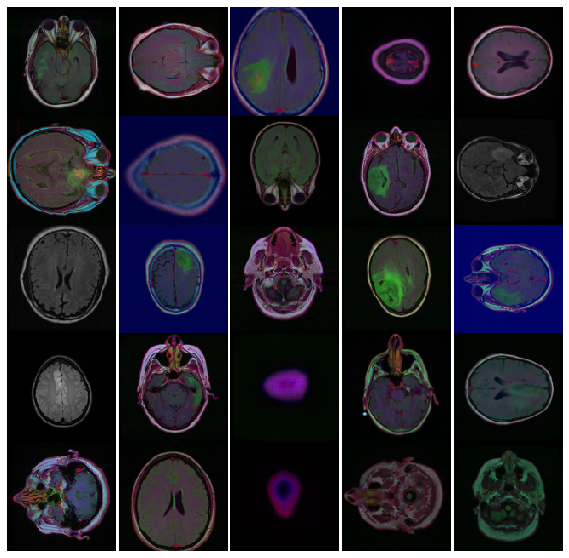

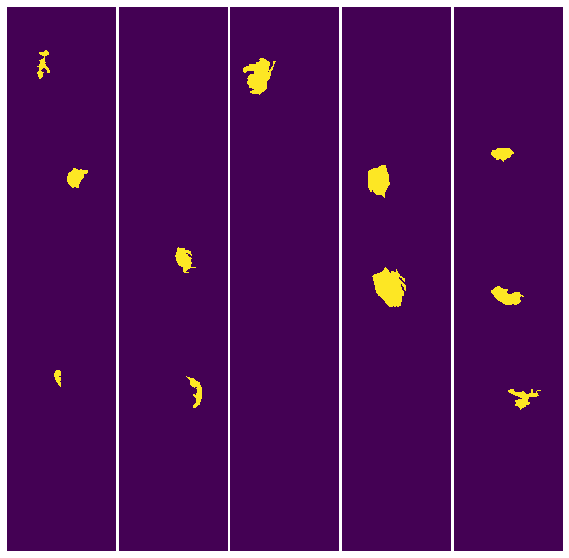

In [23]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
        # normalization
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img * std + mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        # plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img); 
        plt.axis('off')
 
        i += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

## Model
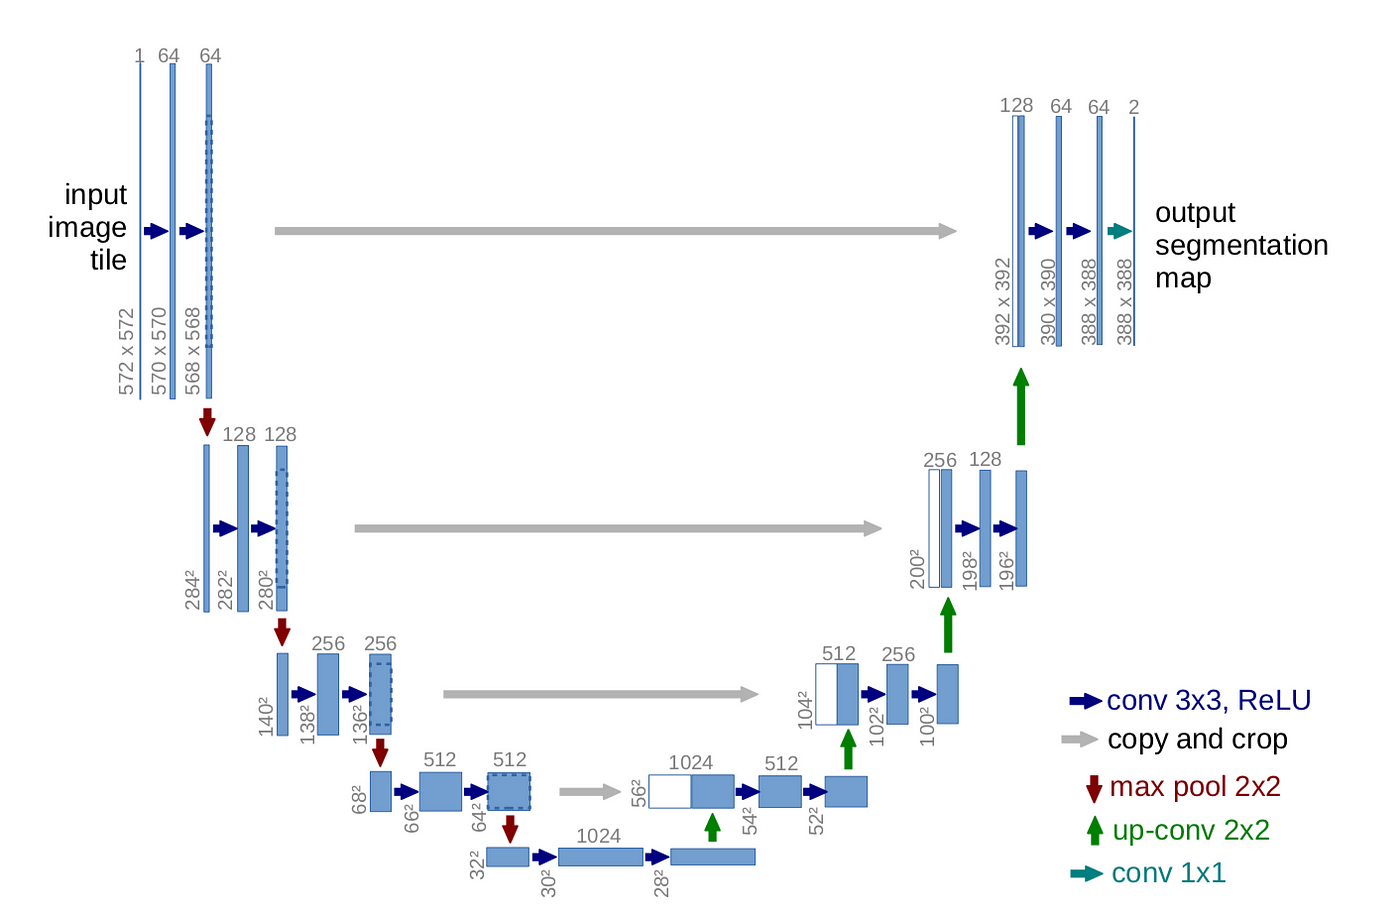!


In [24]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

In [25]:
class UNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Batch - 1d tensor.  N_channels - 1d tensor, IMG_SIZE - 2d tensor.
        # Example: x.shape >>> (10, 3, 256, 256).
        
        # Encoder
        conv1 = self.conv_down1(x)  # <- BATCH, 3, IMG_SIZE  -> BATCH, 64, IMG_SIZE..
        x = self.maxpool(conv1)     # <- BATCH, 64, IMG_SIZE -> BATCH, 64, IMG_SIZE 2x down.
        conv2 = self.conv_down2(x)  # <- BATCH, 64, IMG_SIZE -> BATCH, 128, IMG_SIZE.
        x = self.maxpool(conv2)     # <- BATCH, 128, IMG_SIZE -> BATCH, 128, IMG_SIZE 2x down.
        conv3 = self.conv_down3(x)  # <- BATCH, 128, IMG_SIZE -> BATCH, 256, IMG_SIZE.
        x = self.maxpool(conv3)     # <- BATCH, 256, IMG_SIZE -> BATCH, 256, IMG_SIZE 2x down.
        x = self.conv_down4(x)      # <- BATCH, 256, IMG_SIZE -> BATCH, 512, IMG_SIZE.
        
        # Decoder
        x = self.upsample(x)        # <- BATCH, 512, IMG_SIZE -> BATCH, 512, IMG_SIZE 2x up.        
        x = torch.cat([x, conv3], dim=1) # <- BATCH, 512, IMG_SIZE & BATCH, 256, IMG_SIZE--> BATCH, 768, IMG_SIZE.
        
        x = self.conv_up3(x) #  <- BATCH, 768, IMG_SIZE --> BATCH, 256, IMG_SIZE. 
        x = self.upsample(x)  #  <- BATCH, 256, IMG_SIZE -> BATCH,  256, IMG_SIZE 2x up.   
        x = torch.cat([x, conv2], dim=1) # <- BATCH, 256,IMG_SIZE & BATCH, 128, IMG_SIZE --> BATCH, 384, IMG_SIZE.  

        x = self.conv_up2(x) # <- BATCH, 384, IMG_SIZE --> BATCH, 128 IMG_SIZE. 
        x = self.upsample(x)   # <- BATCH, 128, IMG_SIZE --> BATCH, 128, IMG_SIZE 2x up.     
        x = torch.cat([x, conv1], dim=1) # <- BATCH, 128, IMG_SIZE & BATCH, 64, IMG_SIZE --> BATCH, 192, IMG_SIZE.  
        
        x = self.conv_up1(x) # <- BATCH, 128, IMG_SIZE --> BATCH, 64, IMG_SIZE.
        
        out = self.last_conv(x) # <- BATCH, 64, IMG_SIZE --> BATCH, n_classes, IMG_SIZE.
        out = torch.sigmoid(out)
        
        return out

In [26]:
unet = UNet().to(device)
output = unet(torch.randn(1,3,256,256).to(device))
output.shape

torch.Size([1, 1, 256, 256])

In [27]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0
    return intersection / union

# Check
dice_coef_metric(np.array([0, 0.9]), np.array([0, 1]))

0.9473684210526316

In [28]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)

def bce_dice_loss(inputs, target):
    inputs = inputs.float()
    target = target.float()
    
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]),
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

## Train Model

In [29]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train()  # Enter train mode

        # Store the training loss and dice scores
        losses = []
        train_iou = []

        if lr_scheduler:
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

        for i_step, (data, target) in enumerate(tqdm(train_loader, desc=f"Training epoch {epoch+1}/{num_epochs}")):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())

            # If the score is less than a threshold (0.5), the prediction is 0, otherwise 1
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())

            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            # Reset the gradients
            optimizer.zero_grad()
            # Backprop
            loss.backward()
            # Update the parameters with the computed gradients
            optimizer.step()

            if lr_scheduler:
                lr_scheduler.step()
                
        #torch.save(model.state_dict(), f'{model_name}_{str(epoch)}_epoch.pt')
        val_mean_iou = compute_iou(model, val_loader)

        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)

        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(),
              "\nMean DICE on train:", np.array(train_iou).mean(),
              "\nMean DICE on validation:", val_mean_iou)

    return loss_history, train_history, val_history

def compute_iou(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    #model.eval()
    val_loss = 0

    with torch.no_grad():
        for i_step, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)

            outputs = model(data)
            # print("val_output:", outputs.shape)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            pic_loss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            val_loss += pic_loss

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", val_loss / i_step)

    return val_loss / i_step

In [30]:
unet_optimizer = torch.optim.Adamax(unet.parameters(), lr=1e-3)

# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [31]:
%%time
num_ep = 10

# Train UNet
unet_lh, unet_th, unet_vh = train_model(model_name="Vanilla_UNet", 
                                        model=unet, 
                                        train_loader=train_dataloader,
                                        val_loader=val_dataloader, 
                                        train_loss=bce_dice_loss, 
                                        optimizer=unet_optimizer, 
                                        lr_scheduler=False, 
                                        num_epochs=num_ep)

Training epoch 1/10:   0%|          | 0/94 [00:00<?, ?it/s]

Vanilla_UNet


Training epoch 2/10:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: -44.45961582026583 
Mean DICE on train: 1.39895179577251 
Mean DICE on validation: 1.5575638747688398


Training epoch 3/10:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: -46.72449892632505 
Mean DICE on train: 1.4250613181787597 
Mean DICE on validation: 1.4645135152121995


Training epoch 4/10:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: -46.7795063764491 
Mean DICE on train: 1.4214220280264078 
Mean DICE on validation: 1.5413143860181833


Training epoch 5/10:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: -46.683134141120505 
Mean DICE on train: 1.4057034145205667 
Mean DICE on validation: 1.5239197537012255


Training epoch 6/10:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: -46.85695637033341 
Mean DICE on train: 1.4324460701545638 
Mean DICE on validation: 1.5671416969415513


Training epoch 7/10:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: -46.82373707852465 
Mean DICE on train: 1.4254884350523518 
Mean DICE on validation: 1.5209185198692758


Training epoch 8/10:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: -46.80118311719691 
Mean DICE on train: 1.4172511546411477 
Mean DICE on validation: 1.55712531512908


Training epoch 9/10:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: -46.71949589506109 
Mean DICE on train: 1.4193041259937993 
Mean DICE on validation: 1.535345501767197


Training epoch 10/10:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: -46.82083681035549 
Mean DICE on train: 1.4174961456784694 
Mean DICE on validation: 1.5625523086858466


Training epoch 10/10: 100%|██████████| 94/94 [00:35<00:00,  2.68it/s]


Epoch [9]
Mean loss on train: -46.88425893288978 
Mean DICE on train: 1.4225872354643057 
Mean DICE on validation: 1.5427979187178684
CPU times: user 6min 1s, sys: 5.33 s, total: 6min 7s
Wall time: 6min 15s


### Train History

In [35]:
def plot_model_history(model_name, train_his, val_his, num_epochs):
    x = np.arange(num_epochs)
    
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_his, label='Train dice', lw=3, c='springgreen')
    plt.plot(x, val_his, label='Validation dice', lw=3, c='deeppink')
    plt.title(f'{model_name}', fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Dice', fontsize=15)
    
    fn = str(int(time.time())) + '.png'
    plt.show()
#     plt.savefig(fn, bbox_inches='tight', pad_inches=0.2)

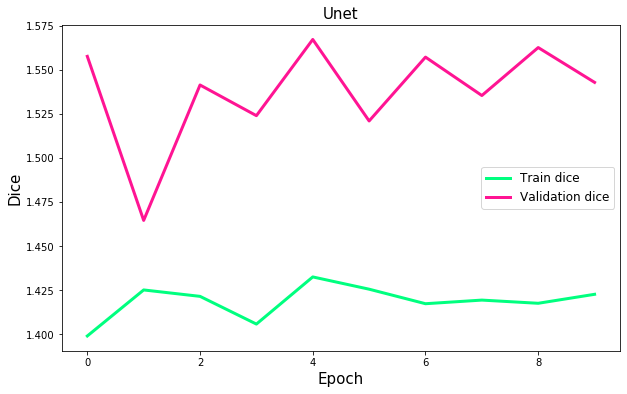

In [36]:
plot_model_history("Unet", unet_th, unet_vh, num_ep)

## Save Model

In [32]:
os.getcwd()

'/kaggle/working'

In [33]:
model_path = os.getcwd()
model_path = os.path.join(model_path, 'unet.pth')  # Use the desired file extension, e.g., 'unet.pth'

# Export and save the model
torch.save(unet.state_dict(), model_path)

## Load Model

In [34]:
unet = UNet().to(device)

# Load the model parameters
unet.load_state_dict(torch.load("unet.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

## Inference

Random test samples

In [ ]:
# image
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = unet(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

In [40]:
test_samples = test_df[test_df["diagnosis"] == 1].sample(105).values


def batch_preds_overlap(model, samples):
    """
    Computes prediction on the dataset
    
    Returns: list with images overlapping with predictions
    
    """
    prediction_overlap = []
    #model.eval():
    for test_sample in samples:

         # sample
        image = cv2.resize(cv2.imread(test_sample[1]),(128, 128))
        image =  image / 255.

        # gt
        ground_truth = cv2.resize(cv2.imread(test_sample[2], 0), (128, 128)).astype("uint8")

        # pred
        prediction = torch.tensor(image).unsqueeze(0).permute(0,3,1,2)
        prediction = model(prediction.to(device).float())
        prediction = prediction.detach().cpu().numpy()[0,0,:,:]

        prediction[np.nonzero(prediction < 0.3)] = 0.0
        prediction[np.nonzero(prediction >= 0.3)] = 255.#1.0
        prediction = prediction.astype("uint8")

        # overlap 
        original_img = cv2.resize(cv2.imread(test_sample[1]),(128, 128))

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)#255,0,0
        prediction_overlap.append(overlap_img)

    return prediction_overlap
    
prediction_overlap_r = batch_preds_overlap(unet, test_samples)